# Experiments - Missing Imputation Methods 

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

from ficaria.missing_imputation import FCMCentroidImputer, FCMParameterImputer, FCMRoughParameterImputer
from ficaria.missing_imputation import FCMKIterativeImputer, FCMInterpolationIterativeImputer, FCMDTIterativeImputer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import time

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

import multiprocessing as mp
from ucimlrepo import fetch_ucirepo 

### Function used for experiments

In [2]:
# ========================================
# Data loading and preprocessing functions
# ========================================

def load_from_uci(id):
    '''
    Loads dataset from UCI Machine Learning Repository. Removes rows with missing values
    and converts categorical variables to string type
    '''
    dataset = fetch_ucirepo(id=id) 
    df = dataset.data.features.copy()

    num_nan_rows = df.isna().any(axis=1).sum() 

    if num_nan_rows > 0:
        df = df.dropna()
        print(f"Removed {num_nan_rows} rows containing missing values.")
    
    vars_df = dataset.variables
    categorical_vars = vars_df[vars_df['type'].str.contains("cat", case=False, na=False)]['name'].tolist()

    if len(categorical_vars) == 0:
        categorical_vars = vars_df[vars_df['type'].str.contains("nominal", case=False, na=False)]['name'].tolist()

    for col in categorical_vars:
        if col in df.columns:
            df[col] = df[col].astype(str)

    return df


def describe_dataset(df):
    '''
    Print basic information about dataset
    '''
    print("Dataset Description:")
    print("--------------------")
    print(f"Number of samples: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")

    WCSS=[]
    for i in range(1,20):
        kmeans=KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(df)
        WCSS.append(kmeans.inertia_)

    plt.figure(figsize=(6,3))
    plt.plot(range(1,20), WCSS)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Optimal number of clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()


def transform_data(df):
    '''
    Transforms categorical variables using One-Hot Encoding and scales numerical variables to [0, 1] range
    '''

    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    num_cols = df.select_dtypes(include=["number"]).columns

    transformer = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(sparse_output=False), cat_cols),
            ("numerical", MinMaxScaler(), num_cols),
        ],
        remainder="passthrough"
    )

    df_transformed = transformer.fit_transform(df)
    df_transformed = pd.DataFrame(df_transformed, columns=transformer.get_feature_names_out())

    return df_transformed

In [3]:
# ==============================
# Evaluation workflow functions
# ==============================

def introduce_missingness(X, missing_fraction, full_rows_fraction=0.05, random_state=42):
    """
    Randomly removes `missing_fraction` of the entries in X. Ensures that at least
    'full_rows_fraction' of the rows remain complete.
    """
    np.random.seed(random_state) 

    X_missing = X.copy()
    n_rows, n_cols = X.shape

    n_full_rows = max(1, int(full_rows_fraction * n_rows))
    full_rows_idx = np.random.choice(n_rows, n_full_rows, replace=False)

    protected_rows = np.zeros(n_rows, dtype=bool)
    protected_rows[full_rows_idx] = True

    total_cells = n_rows * n_cols
    n_missing = int(missing_fraction * total_cells)

    available_rows = np.where(~protected_rows)[0]

    missing_row_idx = np.random.choice(available_rows, n_missing, replace=True)
    missing_col_idx = np.random.randint(0, n_cols, n_missing)

    missing_mask = np.zeros((n_rows, n_cols), dtype=bool)
    missing_mask[missing_row_idx, missing_col_idx] = True

    X_missing.values[missing_mask] = np.nan

    return X_missing, missing_mask


def calculate_metrics(X_original, X_imputed, missing_mask):
    """
    Computes a single global RMSE across all features and all rows,
    using only the positions where missing values were introduced.
    """
    X_orig_vals = X_original.values
    X_imp_vals = X_imputed.values

    true_vals = X_orig_vals[missing_mask]
    imputed_vals = X_imp_vals[missing_mask]

    rmse = root_mean_squared_error(true_vals, imputed_vals)
    mae = mean_absolute_error(true_vals, imputed_vals)
    return rmse, mae


def evaluation_workflow_single(df, df_name, imputers, missing_fractions, n_clusters, n_repeats, output_csv_path):
    results = []

    X = df.copy()

    for repeat in range(1, n_repeats + 1):
        print(f"🔁 Repeat {repeat}/{n_repeats}")

        for frac in missing_fractions:
            print(f"    Missing fraction: {frac}")

            X_missing, missing_mask = introduce_missingness(
                X, missing_fraction=frac, random_state=42 + repeat
            )

            row = {
                "Dataset": df_name,
                "Repeat_ID": repeat,
                "Missing Fraction": frac
            }

            skip_fcmkii = frac > 0.2

            for imp_name, imputer in imputers.items():

                if skip_fcmkii and imp_name == "FCMKIterativeImputer":
                    print(f"        Imputer: {imp_name} skipped")
                    row[f"{imp_name}_RMSE"] = np.nan
                    row[f"{imp_name}_MAE"] = np.nan
                    continue
        
                start_imputer = time.time()

                if n_clusters is not None and hasattr(imputer, "n_clusters"):
                    imputer.n_clusters = n_clusters

                X_imputed = imputer.fit_transform(X_missing)
                X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

                rmse, mae = calculate_metrics(X, X_imputed, missing_mask)
                row[f"{imp_name}_RMSE"] = rmse
                row[f"{imp_name}_MAE"] = mae

                end_imputer = time.time()
                print(f"        Imputer: {imp_name} (took {end_imputer - start_imputer:.2f} sec)")

            results.append(row)

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv_path, index=False)
    
    print(f"\n✅ Results saved to {output_csv_path}")

    return results_df

In [4]:
# ==============================
# Experiment parameters
# ==============================
random_state = 42
n_repeats = 10

imputers = {
    "FCMCentroidImputer": FCMCentroidImputer(n_clusters=3, max_iter=1_000,random_state=random_state), 
    "FCMParameterImputer": FCMParameterImputer(n_clusters=3, max_iter=1_000 ,random_state=random_state), 
    "FCMRoughParameterImputer": FCMRoughParameterImputer(n_clusters=3, max_iter=1_000, max_iter_rough_k=1_000, random_state=random_state),
    # "FCMKIterativeImputer": FCMKIterativeImputer(n_clusters=3, max_FCM_iter=1_000, max_II_iter=5, max_k=5, tol=1e-3),
    "FCMInterpolationIterativeImputer": 
    FCMInterpolationIterativeImputer(n_clusters=3, max_iter=1_000, alpha=0.85, tol=1e-5, sigma=True), 
    #  "FCMDTIterativeImputer": FCMDTIterativeImputer(max_clusters=10, max_iter=100, max_FCM_iter=1_000,
    #       min_samples_leaf=50, learning_rate=0.1, stop_threshold=1.0, alpha=1.0),
    "mean": SimpleImputer(strategy="mean"),
}

missing_fractions = [0.01, 0.05, 0.1, 0.25, 0.5]

### **Wine Quality**

Dataset Description:
--------------------
Number of samples: 6497
Number of features: 11


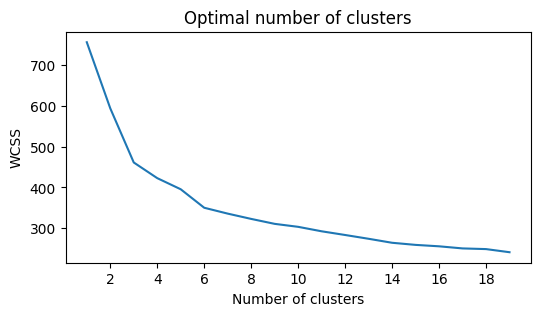

In [7]:
X_wine_quality = load_from_uci(id=186) 
X_wine_quality = transform_data(X_wine_quality)

describe_dataset(X_wine_quality)

The optimal number of clusters was selected as **6**

In [8]:
results_wine_quality = evaluation_workflow_single(
    df=X_wine_quality,
    df_name="wine_quality", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=6, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/wine_quality.csv")

🔁 Repeat 1/10
    Missing fraction: 0.01
        Imputer: FCMCentroidImputer (took 3.40 sec)
        Imputer: FCMParameterImputer (took 3.45 sec)
        Imputer: FCMRoughParameterImputer (took 3.36 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.11 sec)
        Imputer: mean (took 0.00 sec)
    Missing fraction: 0.05
        Imputer: FCMCentroidImputer (took 2.78 sec)
        Imputer: FCMParameterImputer (took 2.81 sec)
        Imputer: FCMRoughParameterImputer (took 2.59 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.44 sec)
        Imputer: mean (took 0.01 sec)
    Missing fraction: 0.1
        Imputer: FCMCentroidImputer (took 1.22 sec)
        Imputer: FCMParameterImputer (took 1.23 sec)
        Imputer: FCMRoughParameterImputer (took 0.88 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.69 sec)
        Imputer: mean (took 0.01 sec)
    Missing fraction: 0.25
        Imputer: FCMCentroidImputer (took 0.94 sec)
        Imputer: FCMParame

### **Bike Sharing**

Dataset Description:
--------------------
Number of samples: 17379
Number of features: 59


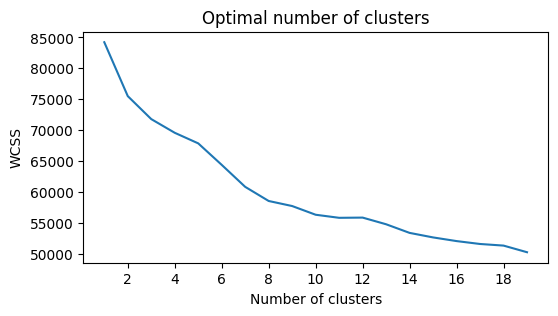

In [13]:
X_bike_sharing = load_from_uci(id=275) 
X_bike_sharing = X_bike_sharing.drop(columns=['dteday'])
X_bike_sharing = transform_data(X_bike_sharing)

describe_dataset(X_bike_sharing)

The optimal number of clusters was selected as **8**

In [14]:
results_bike_sharing = evaluation_workflow_single(
    df=X_bike_sharing,
    df_name="bike_sharing", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=8, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/bike_sharing.csv")

🔁 Repeat 1/10
    Missing fraction: 0.01
        Imputer: FCMCentroidImputer (took 1.42 sec)
        Imputer: FCMParameterImputer (took 1.52 sec)
        Imputer: FCMRoughParameterImputer (took 28.80 sec)
        Imputer: FCMInterpolationIterativeImputer (took 5.32 sec)
        Imputer: mean (took 0.02 sec)
    Missing fraction: 0.05
        Imputer: FCMCentroidImputer (took 8.51 sec)
        Imputer: FCMParameterImputer (took 9.65 sec)
        Imputer: FCMRoughParameterImputer (took 3.55 sec)
        Imputer: FCMInterpolationIterativeImputer (took 14.04 sec)
        Imputer: mean (took 0.04 sec)
    Missing fraction: 0.1
        Imputer: FCMCentroidImputer (took 10.47 sec)
        Imputer: FCMParameterImputer (took 11.81 sec)
        Imputer: FCMRoughParameterImputer (took 5.47 sec)
        Imputer: FCMInterpolationIterativeImputer (took 18.29 sec)
        Imputer: mean (took 0.05 sec)
    Missing fraction: 0.25
        Imputer: FCMCentroidImputer (took 14.23 sec)
        Imputer: FCM

### **Credit Card**

Dataset Description:
--------------------
Number of samples: 30000
Number of features: 23


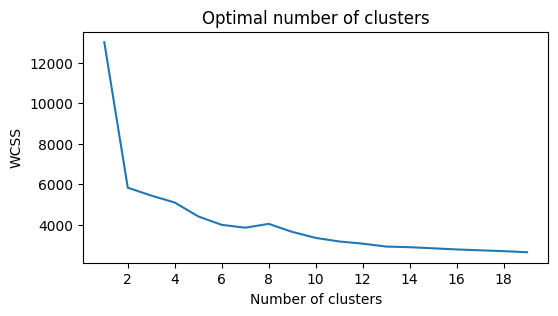

In [37]:
X_default_of_credit_card_clients = load_from_uci(id=350) 
X_default_of_credit_card_clients = transform_data(X_default_of_credit_card_clients)

describe_dataset(X_default_of_credit_card_clients)

The optimal number of clusters was selected as **2**

In [46]:
results_default_of_credit_card_clients = evaluation_workflow_single(
    df=X_default_of_credit_card_clients,
    df_name="credit_card", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=2, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/credit_card.csv")

🔁 Repeat 1/10
    Missing fraction: 0.01
        Imputer: FCMCentroidImputer (took 0.69 sec)
        Imputer: FCMParameterImputer (took 0.74 sec)
        Imputer: FCMRoughParameterImputer (took 24.80 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.78 sec)
        Imputer: mean (took 0.01 sec)
    Missing fraction: 0.05
        Imputer: FCMCentroidImputer (took 3.61 sec)
        Imputer: FCMParameterImputer (took 4.11 sec)
        Imputer: FCMRoughParameterImputer (took 31.96 sec)
        Imputer: FCMInterpolationIterativeImputer (took 4.52 sec)
        Imputer: mean (took 0.02 sec)
    Missing fraction: 0.1
        Imputer: FCMCentroidImputer (took 3.49 sec)
        Imputer: FCMParameterImputer (took 3.71 sec)
        Imputer: FCMRoughParameterImputer (took 6.62 sec)
        Imputer: FCMInterpolationIterativeImputer (took 5.34 sec)
        Imputer: mean (took 0.02 sec)
    Missing fraction: 0.25
        Imputer: FCMCentroidImputer (took 6.80 sec)
        Imputer: FCMPara

### **Glass**

Dataset Description:
--------------------
Number of samples: 214
Number of features: 9


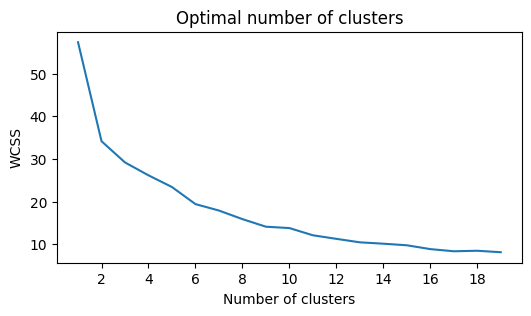

In [25]:
X_glass_identification = load_from_uci(id=42) 
X_glass_identification = transform_data(X_glass_identification)

describe_dataset(X_glass_identification)

The optimal number of clusters was selected as **5**

In [26]:
results_glass = evaluation_workflow_single(
    df=X_glass_identification,
    df_name="glass", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=5, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/glass.csv")

🔁 Repeat 1/10
    Missing fraction: 0.01
        Imputer: FCMCentroidImputer (took 0.01 sec)
        Imputer: FCMParameterImputer (took 0.01 sec)
        Imputer: FCMRoughParameterImputer (took 0.01 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.02 sec)
        Imputer: mean (took 0.00 sec)
    Missing fraction: 0.05
        Imputer: FCMCentroidImputer (took 0.01 sec)
        Imputer: FCMParameterImputer (took 0.01 sec)
        Imputer: FCMRoughParameterImputer (took 0.01 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.09 sec)
        Imputer: mean (took 0.00 sec)
    Missing fraction: 0.1
        Imputer: FCMCentroidImputer (took 0.02 sec)
        Imputer: FCMParameterImputer (took 0.02 sec)
        Imputer: FCMRoughParameterImputer (took 0.01 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.11 sec)
        Imputer: mean (took 0.00 sec)
    Missing fraction: 0.25
        Imputer: FCMCentroidImputer (took 0.03 sec)
        Imputer: FCMParame

### **Sonar**

Dataset Description:
--------------------
Number of samples: 208
Number of features: 60


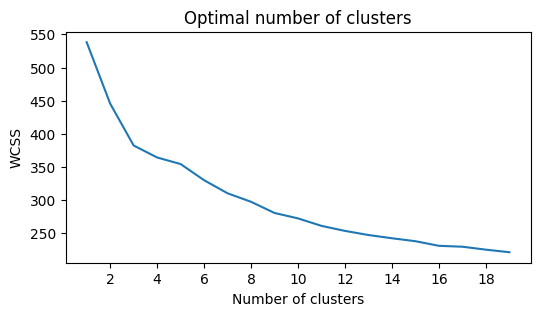

In [27]:
X_connectionist_bench_sonar_mines_vs_rocks = load_from_uci(id=151) 
X_connectionist_bench_sonar_mines_vs_rocks = transform_data(X_connectionist_bench_sonar_mines_vs_rocks)

describe_dataset(X_connectionist_bench_sonar_mines_vs_rocks)

The optimal number of clusters was selected as **4**

In [28]:
results_sonar = evaluation_workflow_single(
    df=X_connectionist_bench_sonar_mines_vs_rocks,
    df_name="sonar", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=8, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/sonar.csv")

🔁 Repeat 1/10
    Missing fraction: 0.01
        Imputer: FCMCentroidImputer (took 0.03 sec)
        Imputer: FCMParameterImputer (took 0.03 sec)
        Imputer: FCMRoughParameterImputer (took 0.02 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.02 sec)
        Imputer: mean (took 0.00 sec)
    Missing fraction: 0.05
        Imputer: FCMCentroidImputer (took 0.03 sec)
        Imputer: FCMParameterImputer (took 0.04 sec)
        Imputer: FCMRoughParameterImputer (took 0.02 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.05 sec)
        Imputer: mean (took 0.00 sec)
    Missing fraction: 0.1
        Imputer: FCMCentroidImputer (took 0.04 sec)
        Imputer: FCMParameterImputer (took 0.04 sec)
        Imputer: FCMRoughParameterImputer (took 0.06 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.07 sec)
        Imputer: mean (took 0.00 sec)
    Missing fraction: 0.25
        Imputer: FCMCentroidImputer (took 0.05 sec)
        Imputer: FCMParame

### **Ionosphere**

Dataset Description:
--------------------
Number of samples: 208
Number of features: 60


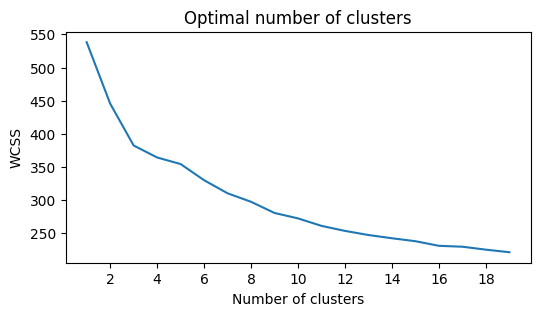

In [29]:
X_ionosphere = load_from_uci(id=151) 
X_ionosphere = transform_data(X_ionosphere)

describe_dataset(X_ionosphere)

The optimal number of clusters was selected as **4**

In [30]:
results_ionosphere = evaluation_workflow_single(
    df=X_ionosphere,
    df_name="ionosphere", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=4, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/ionosphere.csv")

🔁 Repeat 1/10
    Missing fraction: 0.01
        Imputer: FCMCentroidImputer (took 0.06 sec)
        Imputer: FCMParameterImputer (took 0.07 sec)
        Imputer: FCMRoughParameterImputer (took 0.04 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.06 sec)
        Imputer: mean (took 0.01 sec)
    Missing fraction: 0.05
        Imputer: FCMCentroidImputer (took 0.09 sec)
        Imputer: FCMParameterImputer (took 0.11 sec)
        Imputer: FCMRoughParameterImputer (took 0.06 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.12 sec)
        Imputer: mean (took 0.00 sec)
    Missing fraction: 0.1
        Imputer: FCMCentroidImputer (took 0.10 sec)
        Imputer: FCMParameterImputer (took 0.11 sec)
        Imputer: FCMRoughParameterImputer (took 0.08 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.16 sec)
        Imputer: mean (took 0.00 sec)
    Missing fraction: 0.25
        Imputer: FCMCentroidImputer (took 0.12 sec)
        Imputer: FCMParame

### **Concrete** 

Dataset Description:
--------------------
Number of samples: 1030
Number of features: 8


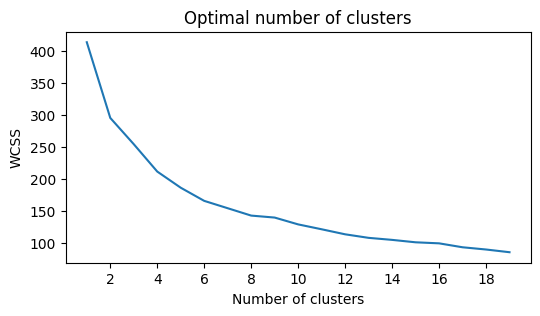

In [31]:
X_concrete_compressive_strength = load_from_uci(id=165) 
X_concrete_compressive_strength = transform_data(X_concrete_compressive_strength)

describe_dataset(X_concrete_compressive_strength)

The optimal number of clusters was selected as **6**

In [32]:
results_concrete_compressive_strength = evaluation_workflow_single(
    df=X_concrete_compressive_strength,
    df_name="concrete", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=6, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/concrete.csv")

🔁 Repeat 1/10
    Missing fraction: 0.01
        Imputer: FCMCentroidImputer (took 0.13 sec)
        Imputer: FCMParameterImputer (took 0.09 sec)
        Imputer: FCMRoughParameterImputer (took 0.06 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.12 sec)
        Imputer: mean (took 0.00 sec)
    Missing fraction: 0.05
        Imputer: FCMCentroidImputer (took 0.12 sec)
        Imputer: FCMParameterImputer (took 0.11 sec)
        Imputer: FCMRoughParameterImputer (took 0.09 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.08 sec)
        Imputer: mean (took 0.00 sec)
    Missing fraction: 0.1
        Imputer: FCMCentroidImputer (took 0.12 sec)
        Imputer: FCMParameterImputer (took 0.15 sec)
        Imputer: FCMRoughParameterImputer (took 0.08 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.67 sec)
        Imputer: mean (took 0.00 sec)
    Missing fraction: 0.25
        Imputer: FCMCentroidImputer (took 0.18 sec)
        Imputer: FCMParame

### **Skin**

Dataset Description:
--------------------
Number of samples: 245057
Number of features: 3


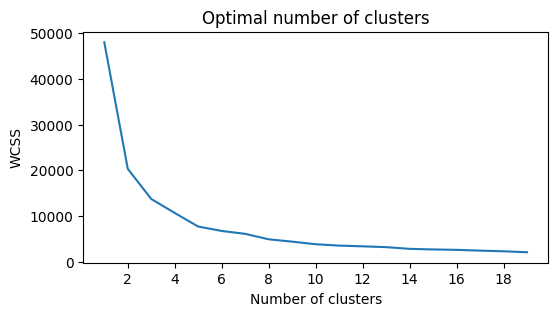

In [5]:
X_skin_segmentation = load_from_uci(id=229) 
X_skin_segmentation = transform_data(X_skin_segmentation)

describe_dataset(X_skin_segmentation)

The optimal number of clusters was selected as **4**

In [6]:
results_skin_segmentation = evaluation_workflow_single(
    df=X_skin_segmentation,
    df_name="skin", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=4, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/skin.csv")

🔁 Repeat 1/10
    Missing fraction: 0.01
        Imputer: FCMCentroidImputer (took 5.59 sec)
        Imputer: FCMParameterImputer (took 5.41 sec)
        Imputer: FCMRoughParameterImputer (took 5.45 sec)
        Imputer: FCMInterpolationIterativeImputer (took 14.48 sec)
        Imputer: mean (took 0.02 sec)
    Missing fraction: 0.05
        Imputer: FCMCentroidImputer (took 7.22 sec)
        Imputer: FCMParameterImputer (took 7.56 sec)
        Imputer: FCMRoughParameterImputer (took 8.15 sec)
        Imputer: FCMInterpolationIterativeImputer (took 4.43 sec)
        Imputer: mean (took 0.02 sec)
    Missing fraction: 0.1
        Imputer: FCMCentroidImputer (took 11.23 sec)
        Imputer: FCMParameterImputer (took 11.79 sec)
        Imputer: FCMRoughParameterImputer (took 9.35 sec)
        Imputer: FCMInterpolationIterativeImputer (took 52.57 sec)
        Imputer: mean (took 0.02 sec)
    Missing fraction: 0.25
        Imputer: FCMCentroidImputer (took 14.00 sec)
        Imputer: FCMP

### **Statalog**

Dataset Description:
--------------------
Number of samples: 58000
Number of features: 7


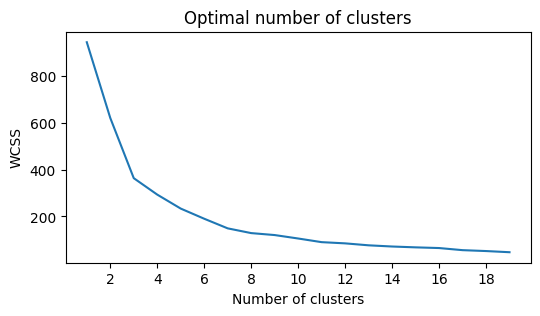

In [47]:
X_statlog_shuttle = load_from_uci(id=148) 
X_statlog_shuttle = transform_data(X_statlog_shuttle)

describe_dataset(X_statlog_shuttle)

The optimal number of clusters was selected as **4**

In [48]:
results_statlog_shuttle = evaluation_workflow_single(
    df=X_statlog_shuttle,
    df_name="statlog", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=4, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/statlog.csv")

🔁 Repeat 1/10
    Missing fraction: 0.01
        Imputer: FCMCentroidImputer (took 2.18 sec)
        Imputer: FCMParameterImputer (took 2.14 sec)
        Imputer: FCMRoughParameterImputer (took 2.02 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.63 sec)
        Imputer: mean (took 0.01 sec)
    Missing fraction: 0.05
        Imputer: FCMCentroidImputer (took 2.96 sec)
        Imputer: FCMParameterImputer (took 3.46 sec)
        Imputer: FCMRoughParameterImputer (took 2.50 sec)
        Imputer: FCMInterpolationIterativeImputer (took 2.20 sec)
        Imputer: mean (took 0.01 sec)
    Missing fraction: 0.1
        Imputer: FCMCentroidImputer (took 3.76 sec)
        Imputer: FCMParameterImputer (took 4.17 sec)
        Imputer: FCMRoughParameterImputer (took 2.71 sec)
        Imputer: FCMInterpolationIterativeImputer (took 3.84 sec)
        Imputer: mean (took 0.01 sec)
    Missing fraction: 0.25
        Imputer: FCMCentroidImputer (took 10.99 sec)
        Imputer: FCMParam

### Results

In [39]:
def summarize_results(results_df):
    metric_cols = [col for col in results_df.columns 
                   if col.endswith("_RMSE") or col.endswith("_MAE")]

    agg_dict = {col: ["mean", "std"] for col in metric_cols}

    summary = (
        results_df
        .groupby("Missing Fraction")
        .agg(agg_dict)
    )

    summary.columns = [
        f"{col}_{stat}" for col, stat in summary.columns
    ]
    
    summary = summary.round(4)

    return summary

10 powtórzeń (bez metod FCMKIterativeImputer, FCMDTIterativeImputer)

In [40]:
results_wine_quality = pd.read_csv("01_MI_results/wine_quality.csv")
summary_wine_quality = summarize_results(results_wine_quality)
summary_wine_quality

,FCMCentroidImputer_RMSE_mean,FCMCentroidImputer_RMSE_std,FCMCentroidImputer_MAE_mean,FCMCentroidImputer_MAE_std,FCMParameterImputer_RMSE_mean,FCMParameterImputer_RMSE_std,FCMParameterImputer_MAE_mean,FCMParameterImputer_MAE_std,FCMRoughParameterImputer_RMSE_mean,FCMRoughParameterImputer_RMSE_std,FCMRoughParameterImputer_MAE_mean,FCMRoughParameterImputer_MAE_std,FCMInterpolationIterativeImputer_RMSE_mean,FCMInterpolationIterativeImputer_RMSE_std,FCMInterpolationIterativeImputer_MAE_mean,FCMInterpolationIterativeImputer_MAE_std,mean_RMSE_mean,mean_RMSE_std,mean_MAE_mean,mean_MAE_std
Missing Fraction,,,,,,,,,,,,,,,,,,,,
0.01,0.0919,0.0032,0.0630,0.0025,0.0972,0.0024,0.0695,0.0019,0.1043,0.0022,0.0758,0.0019,0.1037,0.0022,0.0753,0.0020,0.1043,0.0022,0.0758,0.0020
0.05,0.0905,0.0020,0.0620,0.0008,0.0956,0.0014,0.0683,0.0005,0.1025,0.0015,0.0744,0.0006,0.1020,0.0015,0.0740,0.0007,0.1026,0.0015,0.0744,0.0007
0.10,0.0916,0.0015,0.0628,0.0006,0.0958,0.0021,0.0686,0.0010,0.1029,0.0021,0.0748,0.0010,0.1024,0.0021,0.0743,0.0010,0.1029,0.0021,0.0748,0.0010
0.25,0.0923,0.0007,0.0634,0.0005,0.0956,0.0010,0.0686,0.0006,0.1026,0.0006,0.0748,0.0004,0.1022,0.0006,0.0744,0.0003,0.1026,0.0006,0.0747,0.0002
0.50,0.0950,0.0008,0.0652,0.0004,0.0965,0.0012,0.0690,0.0009,0.1032,0.0008,0.0749,0.0004,0.1028,0.0007,0.0747,0.0004,0.1031,0.0007,0.0749,0.0004


In [41]:
results_bike_sharing = pd.read_csv("01_MI_results/bike_sharing.csv")
summary_bike_sharing = summarize_results(results_bike_sharing)
summary_bike_sharing

,FCMCentroidImputer_RMSE_mean,FCMCentroidImputer_RMSE_std,FCMCentroidImputer_MAE_mean,FCMCentroidImputer_MAE_std,FCMParameterImputer_RMSE_mean,FCMParameterImputer_RMSE_std,FCMParameterImputer_MAE_mean,FCMParameterImputer_MAE_std,FCMRoughParameterImputer_RMSE_mean,FCMRoughParameterImputer_RMSE_std,FCMRoughParameterImputer_MAE_mean,FCMRoughParameterImputer_MAE_std,FCMInterpolationIterativeImputer_RMSE_mean,FCMInterpolationIterativeImputer_RMSE_std,FCMInterpolationIterativeImputer_MAE_mean,FCMInterpolationIterativeImputer_MAE_std,mean_RMSE_mean,mean_RMSE_std,mean_MAE_mean,mean_MAE_std
Missing Fraction,,,,,,,,,,,,,,,,,,,,
0.01,0.2874,0.0043,0.1705,0.0027,0.2874,0.0043,0.1705,0.0027,0.2898,0.0049,0.1709,0.0026,0.2873,0.0043,0.1705,0.0027,0.2874,0.0043,0.1705,0.0027
0.05,0.2872,0.0014,0.1706,0.0010,0.2872,0.0014,0.1706,0.0010,0.2873,0.0014,0.1705,0.0009,0.2871,0.0015,0.1705,0.0009,0.2872,0.0015,0.1705,0.0009
0.10,0.2862,0.0010,0.1697,0.0006,0.2862,0.0010,0.1697,0.0006,0.2877,0.0021,0.1702,0.0010,0.2860,0.0010,0.1696,0.0004,0.2860,0.0010,0.1697,0.0004
0.25,0.2870,0.0003,0.1702,0.0004,0.2870,0.0003,0.1702,0.0004,0.2893,0.0036,0.1708,0.0022,0.2868,0.0003,0.1701,0.0002,0.2868,0.0003,0.1701,0.0002
0.50,0.2871,0.0005,0.1703,0.0005,0.2871,0.0005,0.1703,0.0005,0.2895,0.0040,0.1709,0.0022,0.2870,0.0005,0.1701,0.0003,0.2870,0.0005,0.1701,0.0003


In [42]:
results_glass = pd.read_csv("01_MI_results/glass.csv")
summary_glass = summarize_results(results_glass)
summary_glass

,FCMCentroidImputer_RMSE_mean,FCMCentroidImputer_RMSE_std,FCMCentroidImputer_MAE_mean,FCMCentroidImputer_MAE_std,FCMParameterImputer_RMSE_mean,FCMParameterImputer_RMSE_std,FCMParameterImputer_MAE_mean,FCMParameterImputer_MAE_std,FCMRoughParameterImputer_RMSE_mean,FCMRoughParameterImputer_RMSE_std,FCMRoughParameterImputer_MAE_mean,FCMRoughParameterImputer_MAE_std,FCMInterpolationIterativeImputer_RMSE_mean,FCMInterpolationIterativeImputer_RMSE_std,FCMInterpolationIterativeImputer_MAE_mean,FCMInterpolationIterativeImputer_MAE_std,mean_RMSE_mean,mean_RMSE_std,mean_MAE_mean,mean_MAE_std
Missing Fraction,,,,,,,,,,,,,,,,,,,,
0.01,0.1301,0.0451,0.0817,0.0254,0.1362,0.0487,0.0931,0.0315,0.1740,0.0660,0.1141,0.0395,0.1599,0.0633,0.1113,0.0461,0.1703,0.0560,0.1189,0.0373
0.05,0.1525,0.0170,0.0847,0.0072,0.1378,0.0135,0.0893,0.0067,0.1898,0.0270,0.1181,0.0190,0.1774,0.0126,0.1183,0.0107,0.1757,0.0118,0.1173,0.0083
0.10,0.1551,0.0184,0.0841,0.0116,0.1413,0.0136,0.0890,0.0102,0.2286,0.0179,0.1621,0.0120,0.1709,0.0131,0.1104,0.0096,0.1734,0.0142,0.1162,0.0114
0.25,0.1689,0.0205,0.0958,0.0110,0.1535,0.0175,0.0965,0.0105,0.1953,0.0265,0.1241,0.0271,0.1694,0.0130,0.1116,0.0082,0.1725,0.0065,0.1166,0.0050
0.50,0.1897,0.0134,0.1059,0.0091,0.1696,0.0140,0.1034,0.0084,0.2369,0.0633,0.1553,0.0522,0.1668,0.0059,0.1088,0.0055,0.1765,0.0045,0.1185,0.0031


In [43]:
results_sonar = pd.read_csv("01_MI_results/sonar.csv")
summary_sonar = summarize_results(results_sonar)
summary_sonar

,FCMCentroidImputer_RMSE_mean,FCMCentroidImputer_RMSE_std,FCMCentroidImputer_MAE_mean,FCMCentroidImputer_MAE_std,FCMParameterImputer_RMSE_mean,FCMParameterImputer_RMSE_std,FCMParameterImputer_MAE_mean,FCMParameterImputer_MAE_std,FCMRoughParameterImputer_RMSE_mean,FCMRoughParameterImputer_RMSE_std,FCMRoughParameterImputer_MAE_mean,FCMRoughParameterImputer_MAE_std,FCMInterpolationIterativeImputer_RMSE_mean,FCMInterpolationIterativeImputer_RMSE_std,FCMInterpolationIterativeImputer_MAE_mean,FCMInterpolationIterativeImputer_MAE_std,mean_RMSE_mean,mean_RMSE_std,mean_MAE_mean,mean_MAE_std
Missing Fraction,,,,,,,,,,,,,,,,,,,,
0.01,0.2067,0.0104,0.1605,0.0079,0.2071,0.0105,0.1607,0.0078,0.2081,0.0107,0.1608,0.0080,0.2036,0.0102,0.1580,0.0074,0.2070,0.0107,0.1606,0.0082
0.05,0.2015,0.0072,0.1497,0.0075,0.2046,0.0082,0.1541,0.0062,0.2374,0.0245,0.1782,0.0185,0.2048,0.0039,0.1589,0.0024,0.2074,0.0044,0.1609,0.0026
0.10,0.2178,0.0098,0.1619,0.0063,0.2038,0.0095,0.1531,0.0059,0.2870,0.0348,0.2191,0.0346,0.2065,0.0050,0.1601,0.0033,0.2090,0.0049,0.1621,0.0032
0.25,0.2199,0.0073,0.1622,0.0055,0.2055,0.0070,0.1541,0.0044,0.2883,0.0347,0.2191,0.0351,0.2093,0.0023,0.1623,0.0020,0.2102,0.0024,0.1630,0.0020
0.50,0.2198,0.0064,0.1621,0.0047,0.2041,0.0059,0.1531,0.0032,0.2867,0.0361,0.2180,0.0361,0.2092,0.0019,0.1623,0.0014,0.2094,0.0019,0.1624,0.0014


In [44]:
results_ionosphere = pd.read_csv("01_MI_results/ionosphere.csv")
summary_ionosphere = summarize_results(results_ionosphere)
summary_ionosphere

,FCMCentroidImputer_RMSE_mean,FCMCentroidImputer_RMSE_std,FCMCentroidImputer_MAE_mean,FCMCentroidImputer_MAE_std,FCMParameterImputer_RMSE_mean,FCMParameterImputer_RMSE_std,FCMParameterImputer_MAE_mean,FCMParameterImputer_MAE_std,FCMRoughParameterImputer_RMSE_mean,FCMRoughParameterImputer_RMSE_std,FCMRoughParameterImputer_MAE_mean,FCMRoughParameterImputer_MAE_std,FCMInterpolationIterativeImputer_RMSE_mean,FCMInterpolationIterativeImputer_RMSE_std,FCMInterpolationIterativeImputer_MAE_mean,FCMInterpolationIterativeImputer_MAE_std,mean_RMSE_mean,mean_RMSE_std,mean_MAE_mean,mean_MAE_std
Missing Fraction,,,,,,,,,,,,,,,,,,,,
0.01,0.2065,0.0105,0.1603,0.0080,0.2071,0.0105,0.1607,0.0078,0.2122,0.0101,0.1648,0.0096,0.2043,0.0108,0.1586,0.0083,0.2070,0.0107,0.1606,0.0082
0.05,0.2008,0.0095,0.1496,0.0077,0.2053,0.0084,0.1551,0.0057,0.2348,0.0178,0.1778,0.0175,0.2052,0.0046,0.1593,0.0025,0.2074,0.0044,0.1609,0.0026
0.10,0.2137,0.0071,0.1585,0.0065,0.2060,0.0087,0.1562,0.0070,0.2730,0.0381,0.2024,0.0329,0.2073,0.0051,0.1608,0.0033,0.2090,0.0049,0.1621,0.0032
0.25,0.2143,0.0071,0.1586,0.0052,0.2074,0.0070,0.1570,0.0059,0.2737,0.0400,0.2034,0.0341,0.2095,0.0024,0.1625,0.0020,0.2102,0.0024,0.1630,0.0020
0.50,0.2138,0.0044,0.1583,0.0035,0.2061,0.0053,0.1562,0.0045,0.2729,0.0400,0.2030,0.0342,0.2093,0.0019,0.1623,0.0014,0.2094,0.0019,0.1624,0.0014


In [45]:
results_concrete = pd.read_csv("01_MI_results/concrete.csv")
summary_concrete = summarize_results(results_concrete)
summary_concrete

,FCMCentroidImputer_RMSE_mean,FCMCentroidImputer_RMSE_std,FCMCentroidImputer_MAE_mean,FCMCentroidImputer_MAE_std,FCMParameterImputer_RMSE_mean,FCMParameterImputer_RMSE_std,FCMParameterImputer_MAE_mean,FCMParameterImputer_MAE_std,FCMRoughParameterImputer_RMSE_mean,FCMRoughParameterImputer_RMSE_std,FCMRoughParameterImputer_MAE_mean,FCMRoughParameterImputer_MAE_std,FCMInterpolationIterativeImputer_RMSE_mean,FCMInterpolationIterativeImputer_RMSE_std,FCMInterpolationIterativeImputer_MAE_mean,FCMInterpolationIterativeImputer_MAE_std,mean_RMSE_mean,mean_RMSE_std,mean_MAE_mean,mean_MAE_std
Missing Fraction,,,,,,,,,,,,,,,,,,,,
0.01,0.1897,0.0189,0.1335,0.0109,0.2060,0.0189,0.1627,0.0112,0.2293,0.0240,0.1848,0.0163,0.2134,0.0231,0.1648,0.0233,0.2274,0.0219,0.1848,0.0147
0.05,0.1838,0.0111,0.1295,0.0066,0.1990,0.0084,0.1564,0.0072,0.2268,0.0111,0.1813,0.0091,0.2075,0.0116,0.1617,0.0142,0.2214,0.0094,0.1800,0.0085
0.10,0.1927,0.0098,0.1341,0.0072,0.2044,0.0061,0.1596,0.0056,0.2290,0.0048,0.1829,0.0042,0.2119,0.0112,0.1641,0.0142,0.2257,0.0049,0.1819,0.0049
0.25,0.2002,0.0085,0.1409,0.0069,0.2024,0.0036,0.1585,0.0027,0.2302,0.0046,0.1818,0.0030,0.2178,0.0041,0.1705,0.0045,0.2219,0.0023,0.1793,0.0020
0.50,0.2197,0.0049,0.1542,0.0039,0.2066,0.0043,0.1601,0.0031,0.2375,0.0114,0.1871,0.0075,0.2252,0.0028,0.1776,0.0024,0.2234,0.0018,0.1803,0.0017
